Table for Dupont Stars 

In [6]:
#Dupont Stars
###Import the usual libraries

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack

from uncertainties import ufloat

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

filepath1 = '/Users/joshpovick/Desktop/Research/fits/dupont7.fits' #7as xmactch with gaia

In [7]:
###Restoring the appropriate column names
dupont = Table(fits.getdata(filepath1,1))
dupont['col1'].name = 'NAME'
dupont['col2'].name = 'FILE'
dupont['col3'].name = 'MEDCOUNT'
dupont['col4'].name = 'SNR'
dupont['col5'].name = 'RA'
dupont['col6'].name = 'DEC'
dupont['col7'].name = 'GLON'
dupont['col8'].name = 'GLAT'    
dupont['col9'].name = 'MLON'
dupont['col10'].name = 'MLAT'
dupont['col11'].name = 'VHELIO'
dupont['col12'].name = 'VLSR'
dupont['col13'].name = 'VGSR'
dupont['col14'].name = 'STDEV'
dupont['col15'].name = 'VERR'
dupont['col16'].name = 'V' 
dupont['col17'].name = 'BV'

#find duplicates
def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    # adds all elements it doesn't know yet to seen and all other to seen_twice
    seen_twice = set( x for x in seq if x in seen or seen_add(x) )
    # turn the set into a list (as requested)
    return list( seen_twice )

dups = list_duplicates(dupont['NAME'])

nom1 = np.where(dupont['NAME']==dups[0])
nom2 = np.where(dupont['NAME']==dups[1])
nom3 = np.where(dupont['NAME']==dups[2])
nom4 = np.where(dupont['NAME']==dups[3])
nom5 = np.where(dupont['NAME']==dups[4])

print(dupont['dist'][nom1])
print(dupont['dist'][nom2])
print(dupont['dist'][nom3])
print(dupont['dist'][nom4])
print(dupont['dist'][nom5])

         dist        
---------------------
0.0013329404313994523
 0.001069520681831953
         dist        
---------------------
0.0013850130816626253
0.0002932646947508425
         dist        
---------------------
0.0013427844186541524
 0.001876164058679628
         dist         
----------------------
0.00021683046425657182
0.00028291425940975344
         dist        
---------------------
0.0003870779240463749
0.0004891856993454044
0.0001310590498981866


In [8]:
#remove duplicates
rmidx = [nom1[0][1],nom2[0][0],nom3[0][1],nom4[0][0],nom5[0][0],nom5[0][1]]
keepdupont = np.arange(0,len(dupont),1)
keepdupont = np.delete(keepdupont,rmidx)

pure = dupont[keepdupont]

nums = []
news = []
newidx = []
copyicr = np.copy(pure)
for j in range(len(pure)):
    nums.append((pure['NAME'][j][2:],int(j)))
neworder = sorted(nums)
for k in range(len(neworder)):
    new = ('DI'+neworder[k][0],neworder[k][1])
    news.append(new)
    newidx.append(neworder[k][1])

NAME, RA, DEC, pmra, pmdec, parallax, V, BV, VLSR, TEFF, LMS, Dist

In [9]:
RA = []
DEC = []
pmra = []
pmdec = []
parallax = []
V = []
BV = []
VLSR = []
teff = []
LMS = []
DIST = []

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

for i in range(len(pure)):
    #coordinates
    c = SkyCoord(ra=pure['RA'][i]*u.degree, dec=pure['DEC'][i]*u.degree)
    r = c.ra.to_string(unit=u.hour, sep=':')
    d = c.dec.to_string(unit=u.degree, sep=(':'))
    RA.append(r)
    DEC.append(d)
    c_icrs = SkyCoord(ra=pure['ra'][i]*u.degree, dec=pure['dec'][i]*u.degree)
    c_ms = c_icrs.transform_to(ms.MagellanicStream)
    ms_l,ms_b = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree
    ms_l = ms_l-360
    LMS.append(round(ms_l,2))
    #proper motions
    x = ufloat(pure['pmra'][i],pure['pmra_error'][i])
    y = ufloat(pure['pmdec'][i],pure['pmdec_error'][i])
    pmra.append(u'{:.2uP}'.format(x))
    pmdec.append(u'{:.2uP}'.format(y))
    #parallax
    para = ufloat(pure['parallax'][i],pure['parallax_error'][i])
    parallax.append(u'{:.2uP}'.format(para))
    #distnace
    if pure['parallax'][i]-3*pure['parallax_error'][i] > 0:
        distance = pure['parallax'][i]**(-1)
        distanceerror = np.reciprocal(pure['parallax'][i]**2)*pure['parallax_error'][i]
        diststuff = ufloat(distance,distanceerror)
        DIST.append(u'{:.4uP}'.format(diststuff))
    else:
        DIST.append('...')
    #mag and color
    V.append(round(pure['V'][i],1))
    BV.append(round(pure['BV'][i],2))
    #temperature
    if np.isfinite(pure['teff_val'][i]) == True and np.isfinite(pure['teff_percentile_upper'][i] \
        and np.isfinite(pure['teff_percentile_lower'][i])) == True:
        t = int(round(pure['teff_val'][i]))
        tlow = round(pure['teff_val'][i] - pure['teff_percentile_lower'][i]) 
        tupp = round(pure['teff_percentile_lower'][i] - pure['teff_val'][i]) 
        teff.append(u'${}_{}^{}$'.format(t,tlow,tupp))
    else:
        teff.append('...')
    #VLSR
    VLSR.append(round(pure['VLSR'][i],2))
    
duponttable = Table()
duponttable['NAME'] = pure['NAME']
duponttable['RA'] = Column(RA, description='right ascension')
duponttable['DEC'] = Column(DEC, description='declination')
duponttable['LMS'] = Column(LMS, unit='deg',description='MS longitude')
duponttable['pmra'] = Column(pmra, unit='mas/yr',description='ra proper motion')
duponttable['pmdec'] = Column(pmdec, unit='mas/yr',description='dec proper motion')
duponttable['parallax'] = Column(parallax, unit='mas',description='parallax')
duponttable['DIST'] = Column(DIST, unit='kpc',description='distance to the star')
duponttable['V'] = Column(V,unit='mag',description='V band magnitude')
duponttable['BV'] = Column(BV,unit='mag',description='BV color')
duponttable['VLSR'] = Column(VLSR,unit='km/s',description='vlsr')
duponttable['teff'] = Column(teff,unit='K',description='temperature')

In [10]:
#first half
duptab1 = duponttable[:len(duponttable)//2]
ascii.write(duptab1, format='aastex')

#second half
duptab2 = duponttable[len(duponttable)//2:]
ascii.write(duptab2, format='aastex')

\begin{deluxetable}{cccccccccccc}
\tablehead{\colhead{NAME} & \colhead{RA} & \colhead{DEC} & \colhead{LMS} & \colhead{pmra} & \colhead{pmdec} & \colhead{parallax} & \colhead{DIST} & \colhead{V} & \colhead{BV} & \colhead{VLSR} & \colhead{teff}\\ \colhead{ } & \colhead{ } & \colhead{ } & \colhead{$\mathrm{{}^{\circ}}$} & \colhead{$\mathrm{mas\,yr^{-1}}$} & \colhead{$\mathrm{mas\,yr^{-1}}$} & \colhead{$\mathrm{mas}$} & \colhead{$\mathrm{kpc}$} & \colhead{$\mathrm{mag}$} & \colhead{$\mathrm{mag}$} & \colhead{$\mathrm{km\,s^{-1}}$} & \colhead{$\mathrm{K}$}}
\startdata
DI1020 & 2:20:11.692 & -70:36:08.751 & -13.58 & 3.320±0.079 & 1.292±0.071 & 0.080±0.039 & ... & 16.6 & -0.09 & 347.05 & $6579_301.0^-301.0$ \\
DI1085 & 2:24:16.543 & -70:53:41.202 & -13.14 & 2.07±0.16 & 0.59±0.11 & 0.091±0.070 & ... & 17.1 & -0.02 & 159.89 & $9542_111.0^-111.0$ \\
DI1304 & 2:39:40.099 & -71:12:23.836 & -12.01 & 2.65±0.13 & 0.17±0.13 & 0.008±0.071 & ... & 17.3 & -0.05 & 236.03 & ... \\
DI1316 & 2:46:35.3 & -71:

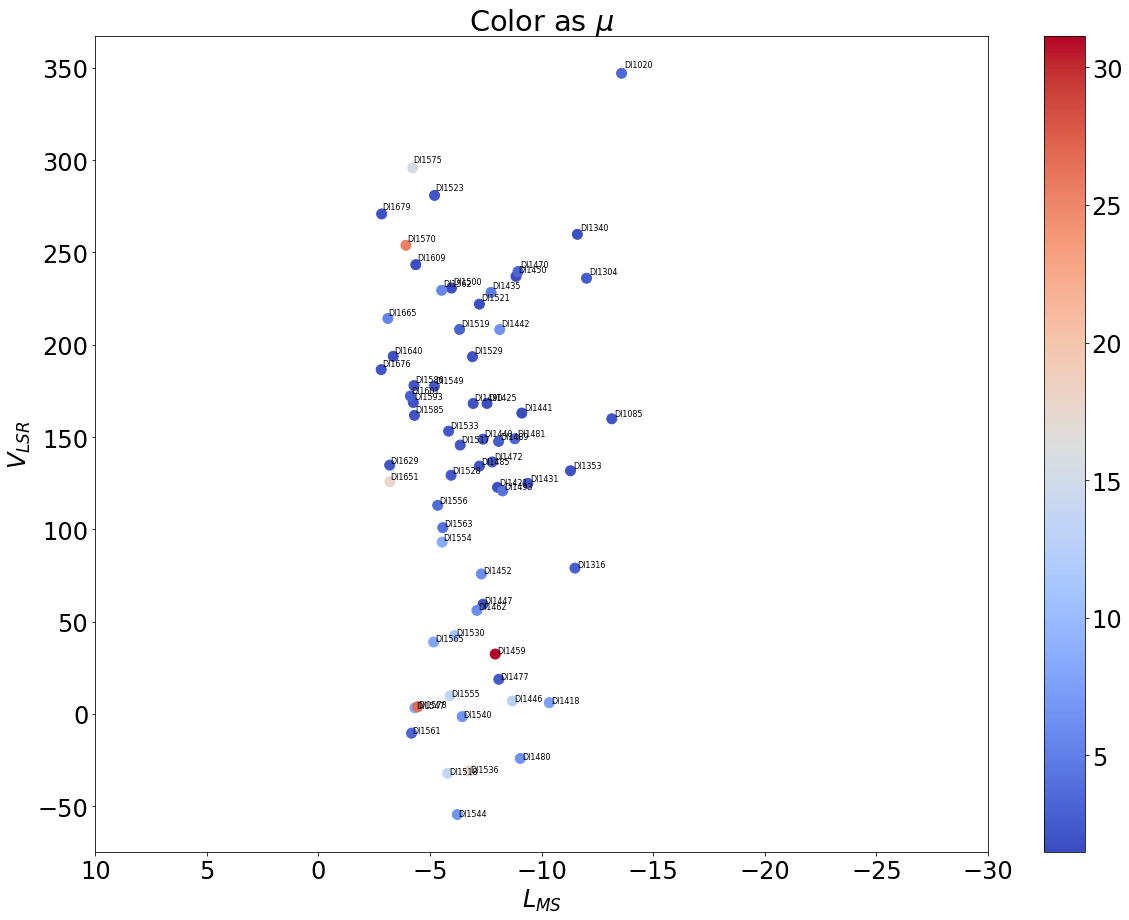

In [11]:
color = np.sqrt(pure['pmra']**2+pure['pmdec']**2)
plt.figure(figsize=(20,15))
plt.scatter(LMS,pure['VLSR'],c=color,s=100,cmap=plt.cm.get_cmap('coolwarm'))

for i in range(len(pure)):
    plt.text(LMS[i]*(1+0.01),pure['VLSR'][i]*(1+0.01),pure['NAME'][i],fontsize=8)

plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{LSR}$')
plt.xlim(10,-30)
plt.colorbar()
plt.title('Color as $\mu$')
plt.savefig('dupontposvel.pdf',bbox_inches='tight')

In [12]:
#Read in stars identified as red giants from gaia
lid = ascii.read('/Users/joshpovick/Desktop/Research/MS_young/lidrg.dat')
sid = ascii.read('/Users/joshpovick/Desktop/Research/MS_young/sidrg.dat')

filepathl = '/Users/joshpovick/Desktop/Research/fits/gaialmcper_1degdia.fits' #ra: 64.24290029 dec:-76.4305723
filepaths = '/Users/joshpovick/Desktop/Research/fits/gaiasmcper_1degdia.fits' #ra: 24.05542837 dec:-74.78460052

lmc = fits.getdata(filepathl,1)
smc = fits.getdata(filepaths,1)

lid = np.array(lid)
sid = np.array(sid)
lrg = []
srg = []

for i in range(len(lid)):
    lrg.append(lid[i][0])
    
for i in range(len(sid)):
    srg.append(sid[i][0])
    
lmc = lmc[lrg]
smc = smc[srg]


#Read in simulated Milky Way data and select stars farther than 10kpc
bes = astropy.io.ascii.read('/Users/joshpovick/Desktop/Research/MS_young/newbesancon.dat')
gt = np.where(bes['Dist']>10)
gt10bes = bes[gt]
mpmra = gt10bes['mux']*10.0
mpmdec = gt10bes['muy']*10.0


In [13]:
###ellipse
def ell(gaia_table,mult_fact):
    x = gaia_table['pmra']
    y = gaia_table['pmdec']
    h = np.nanmedian(gaia_table['pmra'])
    k = np.nanmedian(gaia_table['pmdec'])
    amad = mult_fact*mad(gaia_table['pmra'])
    bmad = mult_fact*mad(gaia_table['pmdec']) 
    return ((x-h)**2/amad**2)+((y-k)**2/bmad**2)

###Median Absolute Deviation
def mad(xdata):
    return np.nanmedian(np.absolute(xdata-np.nanmedian(xdata)))


In [14]:
###make cuts for lmc and smc
cleanl = np.where(np.isfinite(lmc['parallax'])==True)
lmc2  = lmc[cleanl]
cleanl  = np.where(np.isfinite(lmc2['parallax_error'])==True)
lmc3 = lmc2[cleanl]
cleanl  = np.where(lmc3['parallax'] <= 3*lmc3['parallax_error']) #\varpi <= 3*\varpi
cleanlmc = Table(lmc3[cleanl])
outl = np.where(ell(cleanlmc,2)<=1)
outlmc = cleanlmc[outl]
outlra  = outlmc['pmra']
outldec = outlmc['pmdec']

cleans = np.where(np.isfinite(smc['pmra'])==True)
smc = smc[cleans]
cleans = np.where(np.isfinite(smc['pmdec'])==True)
cleansmc = smc[cleans]
outs = np.where(ell(cleansmc,2)<=1)
outsmc = cleansmc[outs]
outsra = outsmc['pmra']
outsdec = outsmc['pmdec']


In [15]:
#Median plot with mad ellipses
lfact = 4.0
sfact = 4.0
gtfact = 1.0

outells  = [Ellipse(xy = (np.nanmedian(outlra),np.nanmedian(outldec)),width=mad(outlra)*lfact,\
            height=mad(outldec)*lfact,color='deepskyblue'), Ellipse(xy = (np.nanmedian(outsra),\
            np.nanmedian(outsdec)), width=mad(outsra)*sfact,height=mad(outsdec)*sfact,color='red'), \
            Ellipse(xy = (np.nanmedian(mpmra), np.nanmedian(mpmdec)), \
            width=mad(mpmra)*gtfact,height=mad(mpmdec)*gtfact, color='k',alpha =0.075)]

plt.figure(figsize=[30,30])
a = plt.subplot(111, aspect='equal')

for e in outells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.4)
    a.add_artist(e)

plt.scatter(np.nanmedian(outlra),np.nanmedian(outldec),c='deepskyblue',marker='*',s=300,label='med LMC $\mu$')
plt.scatter(np.nanmedian(outsra),np.nanmedian(outsdec),c='red',marker='*',s=300,label='med SMC $\mu$')
plt.scatter(np.nanmedian(mpmra),np.nanmedian(mpmdec),c='grey',marker='*',s=300,label='med MW $\mu$')

plt.scatter(pure['pmra'],pure['pmdec'],c=pure['VLSR'],s=100,cmap=plt.cm.get_cmap('gnuplot'),\
            alpha=1)

plt.colorbar()

window = np.where((np.sqrt(pure['pmra']**2+pure['pmdec']**2)<=100) & (np.sqrt(pure['pmdec']**2+pure['pmdec']**2)>0)) 
windowpure = pure[window]

for i in range(len(windowpure)):
    plt.text(windowpure['pmra'][i]*(1),windowpure['pmdec'][i]*(1),windowpure['NAME'][i],fontsize=8)

plt.title('Color as VLSR')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.xlim(0,6)
plt.ylim(-3,4)
plt.savefig('dupontstars.pdf',bbox_inches='tight')
plt.legend()
plt.show()

In [116]:
print(pmra)

['3.320±0.079', '2.07±0.16', '2.65±0.13', '2.79±0.12', '1.75±0.12', '1.64±0.13', '1.77±0.16', '1.57±0.13', '1.89±0.11', '4.304±0.088', '2.36±0.12', '-0.27±0.12', '4.363±0.062', '12.166±0.066', '1.48±0.13', '1.489±0.057', '6.055±0.052', '6.12±0.13', '5.64±0.13', '3.24±0.11', '2.140±0.093', '1.74±0.12', '1.247±0.030', '3.06±0.10', '1.97±0.12', '2.30±0.12', '2.02±0.13', '3.2±1.8', '1.57±0.15', '2.12±0.14', '12.990±0.030', '2.49±0.55', '1.71±0.12', '1.93±0.17', '2.35±0.16', '1.83±0.11', '-3.275±0.058', '2.30±0.12', '-15.529±0.095', '5.42±0.11', '4.579±0.041', '4.915±0.092', '2.30±0.15', '7.344±0.064', '9.992±0.054', '2.542±0.039', '3.04±0.15', '5.563±0.042', '3.562±0.064', '6.844±0.099', '10.032±0.085', '14.277±0.030', '10.70±0.11', '2.12±0.18', '2.18±0.13', '2.10±0.16', '-5.0±2.8', '2.86±0.21', '1.64±0.12', '0.17±0.12', '1.79±0.13', '13.612±0.063', '5.391±0.061', '2.084±0.068', '1.79±0.16']


In [4]:
len(dupont)

71